# Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα
## Εργασία 1: Επιβλεπόμενη Μάθηση - Ταξινόμηση
### Ομάδα 44
* Βασιλάκος Μιχαήλ <br>
Α.Μ.: 03117069
* Γαβαλάς Παντελεήμων <br>
Α.Μ.: 03117075

In [1]:
# import used modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Μέρος 1: UCI dataset
Το dataset του UCI Machine Learning Repository που αντιστοιχεί στην ομάδα μας είναι το [HCC Survival Data Set](https://archive.ics.uci.edu/ml/datasets/HCC+Survival). Το συγκεκριμένο dataset περιέχει πληροφορίες σχετικά με την επιβίωση ασθενών με Ηπατοκυτταρικό καρκίνωμα (HCC) σε διάστημα ενός χρόνου από τη συλλογή των στοιχείων που δίνονται στο dataset. Δίνονται 49 features, 23 εκ των οποίων είναι κατηγορικά ενώ τα υπόλοιπα 26 είναι διατεταγμένα.

### Εισαγωγή και επισκόπηση δεδομένων

Αρχικά φορτώνουμε το dataset στο notebook και ελέγχουμε τα πρώτα στοιχεία του καθώς και τις διαστάσεις του.

In [2]:
# read dataset
df = pd.read_csv("hcc-data.txt", header=None, na_values=["?"])
print(df.head(), df.shape)

   0    1   2    3    4    5    6   ...   43    44   45    46    47    48  49
0   1  0.0   1  0.0  0.0  0.0  0.0  ...  1.0   3.5  0.5   NaN   NaN   NaN   1
1   0  NaN   0  0.0  0.0  0.0  1.0  ...  1.0   1.8  NaN   NaN   NaN   NaN   1
2   1  0.0   1  1.0  0.0  1.0  0.0  ...  5.0  13.0  0.1  28.0   6.0  16.0   1
3   1  1.0   1  0.0  0.0  0.0  0.0  ...  2.0  15.7  0.2   NaN   NaN   NaN   0
4   1  1.0   1  1.0  0.0  1.0  0.0  ...  1.0   9.0  NaN  59.0  15.0  22.0   1

[5 rows x 50 columns] (165, 50)


Το αρχείο text δεν χρειάστηκε κάποια μετατροπή για να εισαχθεί στο notebook. Βλέπουμε πως υπάρχουν 50 στήλες στο dataframe, το οποίο σημαίνει πως έχουμε 49 χαρακτηριστικά και 1 ετικέτα. Από την περιγραφή των χαρακτηριστικών στο UCI Repository βλέπουμε πως τα πρώτα 23 χαρακτηριστικά είναι μη διατεταγμένα (κατηγορικά) και είναι:
* Gender (1: Άνδρας; 0: Γυναίκα)
* Symptoms (1: Ναι; 0: Όχι)
* Alcohol (1: Ναι; 0: Όχι)
* Hepatitis B Surface Antigen (1: Ναι; 0: Όχι)
* Hepatitis B e Antigen (1: Ναι; 0: Όχι)
* Hepatitis B Core Antibody (1: Ναι; 0: Όχι)
* Hepatitis C Virus Antibody (1: Ναι; 0: Όχι)
* Cirrhosis (1: Ναι; 0: Όχι)
* Endemic Countries (1: Ναι; 0: Όχι)
* Smoking (1: Ναι; 0: Όχι)
* Diabetes (1: Ναι; 0: Όχι)
* Obesity (1: Ναι; 0: Όχι)
* Hemochromatosis (1: Ναι; 0: Όχι)
* Arterial Hypertension (1: Ναι; 0: Όχι)
* Chronic Renal Insufficiency (1: Ναι; 0: Όχι)
* Human Immunodeficiency Virus (1: Ναι; 0: Όχι)
* Nonalcoholic Steatohepatitis (1: Ναι; 0: Όχι)
* Esophageal Varices (1: Ναι; 0: Όχι)
* Splenomegaly (1: Ναι; 0: Όχι)
* Portal Hypertension (1: Ναι; 0: Όχι)
* Portal Vein Thrombosis (1: Ναι; 0: Όχι)
* Liver Metastasis (1: Ναι; 0: Όχι)
* Radiological Hallmark  (1: Ναι; 0: Όχι)

Το dataset δεν περιέχει επικεφαλίδες ούτε αρίθμηση σειρών. Οι ετικέτες των κλάσεων είναι στην 50η στήλη και λαμβάνουν τιμές 1 και 0, όπου το 1 εκφράζει την επιβίωση του ασθενή στον 1 χρόνο ενώ το 0 το αντίθετο.

In [3]:
# find missing values
print("Total missing values:", df.isnull().sum(axis=1).sum())
# find samples with missing values
missing_samples = df.isnull().any(axis=1).sum()
print("Number of samples with missing values: {} which represents {:.2f}% \
of total samples".format(missing_samples, missing_samples/df.shape[0]*100))
# find features with missing values
missing_cols = df.isnull().sum(axis=0)
missing_cols_percent = ["{:.1f}%".format(x/df.shape[0]*100) for x in missing_cols]
print("Percentage of samples with missing features:")
for i in range(len(missing_cols_percent)-1):
  print("Feature {}: {}".format(i, missing_cols_percent[i]))

Total missing values: 826
Number of samples with missing values: 157 which represents 95.15% of total samples
Percentage of samples with missing features:
Feature 0: 0.0%
Feature 1: 10.9%
Feature 2: 0.0%
Feature 3: 10.3%
Feature 4: 23.6%
Feature 5: 14.5%
Feature 6: 5.5%
Feature 7: 0.0%
Feature 8: 23.6%
Feature 9: 24.8%
Feature 10: 1.8%
Feature 11: 6.1%
Feature 12: 13.9%
Feature 13: 1.8%
Feature 14: 1.2%
Feature 15: 8.5%
Feature 16: 13.3%
Feature 17: 31.5%
Feature 18: 9.1%
Feature 19: 6.7%
Feature 20: 1.8%
Feature 21: 2.4%
Feature 22: 1.2%
Feature 23: 0.0%
Feature 24: 29.1%
Feature 25: 32.1%
Feature 26: 0.0%
Feature 27: 0.6%
Feature 28: 1.2%
Feature 29: 2.4%
Feature 30: 4.8%
Feature 31: 1.8%
Feature 32: 1.8%
Feature 33: 1.8%
Feature 34: 1.8%
Feature 35: 3.6%
Feature 36: 3.0%
Feature 37: 2.4%
Feature 38: 1.8%
Feature 39: 1.8%
Feature 40: 1.8%
Feature 41: 6.7%
Feature 42: 4.2%
Feature 43: 1.2%
Feature 44: 12.1%
Feature 45: 26.7%
Feature 46: 47.9%
Feature 47: 48.5%
Feature 48: 48.5%


Παρατηρούμε πως μας λείπουν 826 τιμές συνολικά. Δεδομένου ότι έχουμε 49 χαρακτηριστικά και 165 δείγματα μας λείπουν $\frac{826}{49*165}*100\% = 10.2\%$ των τιμών του dataset. Επιπλέον, είδαμε πως πάνω από το 95% των δειγμάτων έχουν τουλάχιστον μία τιμή που απουσιάζει, οπότε δεν είναι δυνατή η αφαίρεση των δειγμάτων των οποίων οι τιμές απουσιάζουν. Επίσης είδαμε πως 7 από τα 49 χαρακτηριστικά απουσιάζουν για πάνω από το 25% των δειγμάτων, ενώ 3 εξ αυτών απουσιάζουν για περίπου τα μισά δείγματα.

In [4]:
# count instances of each class
class1 = df.iloc[:,49].sum()
class0 = df.shape[0] - class1
print("Class 0 has {} samples which represents {:.1f}% of all samples".format
      (class0, class0/df.shape[0]*100))
print("Class 1 has {} samples which represents {:.1f}% of all samples".format
      (class1, class1/df.shape[0]*100))

Class 0 has 63 samples which represents 38.2% of all samples
Class 1 has 102 samples which represents 61.8% of all samples


Παρατηρούμε πως η κλάση 1 (ο ασθενής ζει) αντιπροσωπεύει το 61.8% των δειγμάτων του dataset, έναντι του 38.2% που αντιστοιχεί στην κλάση 0 (ο ασθενής πεθαίνει). Αυτό σημαίνει πως το dataset δεν είναι ισορροπημένο και συνεπώς απαιτείται ειδικός χειρισμός για την αποτελεσματικότερη χρήση του.

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67,137.0,15.0,0,1.0,1.0,1.53,95.0,13.7,106.6,4.9,99.0,3.4,2.1,34.0,41.0,183.0,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,62,0.0,NaN,0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,78,50.0,50.0,2,1.0,2.0,0.96,5.8,8.9,79.8,8.4,472.0,3.3,0.4,58.0,68.0,202.0,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,77,40.0,30.0,0,1.0,1.0,0.95,2440.0,13.4,97.1,9.0,279.0,3.7,0.4,16.0,64.0,94.0,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,76,100.0,30.0,0,1.0,1.0,0.94,49.0,14.3,95.1,6.4,199.0,4.1,0.7,147.0,306.0,173.0,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


### Προετοιμασία δεδομένων

Χωρίζουμε το dataset σε δύο μέρη ώστε να δημιουργήσουμε τα train και test sets με το test set να αποτελεί το 30% των δειγμάτων.

In [6]:
from sklearn.model_selection import train_test_split

# differentiate labels from features
X_df = df.iloc[:,:49].copy()
y_df = df.iloc[:,49].copy()

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=.3)

Επειδή όπως δείξαμε παραπάνω στα features 46, 47 και 48 λείπουν οι τιμές για περίπου τα μισά δείγματα, η συμπλήρωσή τους δεν αποτελεί καλή πρακτική και για τον λόγο αυτό τα αφαιρούμε από τα δεδομένα μας.

In [7]:
X_train.drop([46, 47, 48], axis=1, inplace=True)
X_test.drop([46, 47, 48], axis=1, inplace=True)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
43,1,0.0,1,NaN,NaN,NaN,NaN,1,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,0.0,0.0,1.0,71,75.0,NaN,0,1.0,1.0,1.17,5.0,15.1,104.1,4.3,65000.0,3.8,2.5,61.0,56.0,239.0,56.0,7.3,0.70,1.0,2.00,0.2
49,1,NaN,1,0.0,NaN,1.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,58,NaN,40.0,0,1.0,1.0,1.49,20.0,15.0,96.7,9.0,78.0,4.6,2.1,40.0,49.0,137.0,109.0,7.6,0.80,1.0,2.00,0.4
138,0,1.0,0,0.0,0.0,1.0,0.0,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,55,0.0,NaN,0,1.0,1.0,1.19,4.9,13.6,97.3,5400.0,133000.0,4.5,0.9,54.0,63.0,487.0,89.0,7.8,0.78,2.0,3.32,NaN
98,1,0.0,1,0.0,NaN,0.0,0.0,1,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73,NaN,NaN,0,1.0,1.0,1.23,5.5,13.1,89.6,6.1,160000.0,3.2,0.8,28.0,30.0,90.0,92.0,6.3,0.86,5.0,NaN,NaN
100,1,1.0,1,NaN,NaN,NaN,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,1.0,1.0,0.0,1.0,0.0,93,NaN,0.0,2,1.0,1.0,1.16,2785.0,12.0,94.4,7.9,78000.0,2.6,3.5,26.0,34.0,339.0,297.0,5.7,2.19,5.0,NaN,1.5


Εφόσον τα features 0-22 είναι categorical επιλέγουμε να τα συμπληρώσουμε με τις πιο συχνές τιμές για κάθε feature στο training set, ενώ την ίδια τιμή συμπληρώνουμε και στο test set, αφού όποια αλλαγή κάνουμε στα δεδομένα μας πρέπει να γίνεται με βάση την επεξεργασία μόνο των δεδομένων στο training set.

Για τα υπόλοιπα features θα αντικαταστήσουμε τον μέσο όρο των τιμών στο training set.

In [8]:
from sklearn.impute import SimpleImputer
imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")

In [9]:
X_train.iloc[:,:23] = imp_freq.fit_transform(X_train.iloc[:,:23])
X_train.iloc[:,23:] = imp_mean.fit_transform(X_train.iloc[:,23:])

Επιβεβαιώνουμε πως δεν υπάρχουν πλέον κενά πεδία στο training set.

In [10]:
X_train.isnull().any().any()

False

Τα κατηγορικά δεδομένα δεν χρειάζεται να τα τροποποιήσουμε με κάποια τεχνική (π.χ. one-hot encoding) διότι ήδη βρίσκονται σε μορφή Ναι-Όχι (με το 1 να αναπαριστά το "Ναι" και το 0 το "Όχι").

Επαναλαμβάνουμε με τα δεδομένα του test set χρησιμοποιόντας πληροφορία αποκλειστικά από τα δεδομένα του training set ώστε να μην έχουμε απουσιάζουσες τιμές.

In [11]:
X_test.iloc[:,:23] = imp_freq.transform(X_test.iloc[:,:23])
X_test.iloc[:,23:] = imp_mean.transform(X_test.iloc[:,23:])

Ελέγχουμε ξανά για κενά πεδία.

In [12]:
X_test.isnull().any().any()

False

### Ταξινόμηση
Οι ταξινομητές που θα μελετηθούν είναι οι:
* dummy
* Gaussian Naive Bayes (GNB)
* KNearestNeighbors (kNN)
* Logistic Regression (LR)

Οι μετρικές αξιολόγησης που θα χρησιμοποιηθούν είναι οι:
* Ορθότητα (accuracy)
* F1-score

Για όλα τα πειράματα θα χρησιμοποιήσουμε 10-fold cross-validation.

#### Επίδοση out-of-the-box
Για να έχουμε μία βάση σύγκρισης θα εκτελέσουμε αρχικά το πείραμα αφήνοντας τις υπερπαραμέτρους των ταξινομητών στις default τιμές τους.

Αρχικά ορίζουμε τους ταξινομητές.

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

dummy_stratified = DummyClassifier(strategy="stratified")
dummy_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_uniform = DummyClassifier(strategy="uniform")
dummy_const_0 = DummyClassifier(strategy="constant", constant=0)
dummy_const_1 = DummyClassifier(strategy="constant", constant=1)

gnb = GaussianNB()
knn = KNeighborsClassifier()
lr = LogisticRegression()

Στη συνέχεια εκπαιδεύουμε τους ταξινομητές και συγκρίνουμε τα αποτελέσματά τους.

In [14]:
from sklearn.metrics import accuracy_score, f1_score

ootb_accuracy = {}

dummy_stratified.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (stratified)"] = accuracy_score(y_test, dummy_stratified.predict(X_test))
dummy_most_frequent.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (most frequent)"] = accuracy_score(y_test, dummy_most_frequent.predict(X_test))
dummy_uniform.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (uniform)"] = accuracy_score(y_test, dummy_uniform.predict(X_test))
dummy_const_0.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (constant 0)"] = accuracy_score(y_test, dummy_const_0.predict(X_test))
dummy_const_1.fit(X_train, y_train)
ootb_accuracy["Dummy Classifier (constant 1)"] = accuracy_score(y_test, dummy_const_1.predict(X_test))

gnb.fit(X_train, y_train)
ootb_accuracy["Gaussian Naive-Bayes"] = accuracy_score(y_test, gnb.predict(X_test))
knn.fit(X_train, y_train)
ootb_accuracy["K Nearest Neighbors"] = accuracy_score(y_test, knn.predict(X_test))
lr.fit(X_train, y_train)
ootb_accuracy["Logistic Regression"] = accuracy_score(y_test, lr.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


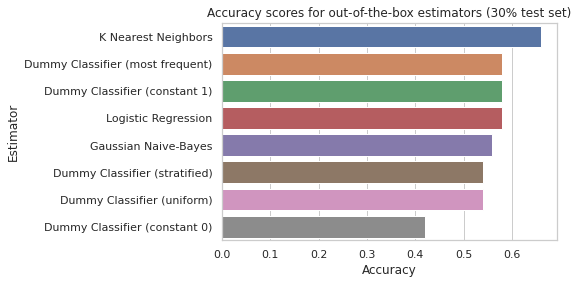

In [15]:
sorted_accuracy = [(k, ootb_accuracy[k]) for k in sorted(ootb_accuracy, key=ootb_accuracy.get, reverse=True)]
acc_df = pd.DataFrame.from_dict(sorted_accuracy)

sns.set_theme(style="whitegrid")
sns.barplot(y=acc_df.iloc[:,0], x=acc_df.iloc[:,1], data=acc_df)
plt.xlabel("Accuracy")
plt.ylabel("Estimator")
plt.title("Accuracy scores for out-of-the-box estimators (30% test set)")
plt.show()

In [16]:
ootb_f1 = {}

dummy_stratified.fit(X_train, y_train)
ootb_f1["Dummy Classifier (stratified)"] = f1_score(y_test, dummy_stratified.predict(X_test))
dummy_most_frequent.fit(X_train, y_train)
ootb_f1["Dummy Classifier (most frequent)"] = f1_score(y_test, dummy_most_frequent.predict(X_test))
dummy_uniform.fit(X_train, y_train)
ootb_f1["Dummy Classifier (uniform)"] = f1_score(y_test, dummy_uniform.predict(X_test))
dummy_const_0.fit(X_train, y_train)
ootb_f1["Dummy Classifier (constant 0)"] = f1_score(y_test, dummy_const_0.predict(X_test))
dummy_const_1.fit(X_train, y_train)
ootb_f1["Dummy Classifier (constant 1)"] = f1_score(y_test, dummy_const_1.predict(X_test))

gnb.fit(X_train, y_train)
ootb_f1["Gaussian Naive-Bayes"] = f1_score(y_test, gnb.predict(X_test))
knn.fit(X_train, y_train)
ootb_f1["K Nearest Neighbors"] = f1_score(y_test, knn.predict(X_test))
lr.fit(X_train, y_train)
ootb_f1["Logistic Regression"] = f1_score(y_test, lr.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


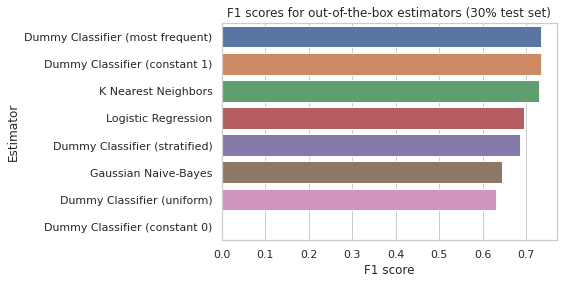

In [17]:
sorted_f1 = [(k, ootb_f1[k]) for k in sorted(ootb_f1, key=ootb_f1.get, reverse=True)]
f1_df = pd.DataFrame.from_dict(sorted_f1)

sns.set_theme(style="whitegrid")
sns.barplot(y=f1_df.iloc[:,0], x=f1_df.iloc[:,1], data=f1_df)
plt.xlabel("F1 score")
plt.ylabel("Estimator")
plt.title("F1 scores for out-of-the-box estimators (30% test set)")
plt.show()

In [18]:
print(ootb_accuracy)
print(ootb_f1)

{'Dummy Classifier (stratified)': 0.54, 'Dummy Classifier (most frequent)': 0.58, 'Dummy Classifier (uniform)': 0.54, 'Dummy Classifier (constant 0)': 0.42, 'Dummy Classifier (constant 1)': 0.58, 'Gaussian Naive-Bayes': 0.56, 'K Nearest Neighbors': 0.66, 'Logistic Regression': 0.58}
{'Dummy Classifier (stratified)': 0.6865671641791046, 'Dummy Classifier (most frequent)': 0.7341772151898733, 'Dummy Classifier (uniform)': 0.6315789473684211, 'Dummy Classifier (constant 0)': 0.0, 'Dummy Classifier (constant 1)': 0.7341772151898733, 'Gaussian Naive-Bayes': 0.6451612903225807, 'K Nearest Neighbors': 0.7301587301587301, 'Logistic Regression': 0.6956521739130435}


|       Classifier      | Accuracy | F1 score |
|:---------------------:|:--------:|:--------:|
| Dummy (most frequent) |   0.62   |   0.77   |
|   Dummy (constant 1)  |   0.62   |   0.77   |
|  Logistic Regression  |   0.62   |   0.74   |
|  Gaussian Naive-Bayes |   0.58   |   0.70   |
|  K Nearest Neighbors  |   0.54   |   0.69   |
|   Dummy (stratified)  |   0.41   |   0.67   |
|    Dummy (uniform)    |   0.48   |   0.60   |
|   Dummy (constant 0)  |   0.38   |   0.00   |

Παρατηρούμε πως οι ταξινομητές δεν έχουν ιδιαίτερα καλή επίδοση, καθώς ο dummy ταξινομητής που προβλέπει πάντα 1 έχει τη μεγαλύτερη ακρίβεια (62%) και το καλύτερο f1-score (77%), ενώ οι ταξινομητές μας έχουν ακρίβεια που κυμαίνεται από 62% μέχρι 54% και f1-score από 70% μέχρι 69%. Οι καλές επιδόσεις του dummy ταξινομητή που ακολουθεί τη στρατηγική most frequent οφείλονται στο έντονο class imbalance που εμφανίζεται στο dataset.

Από τους ταξινομητές, εξαιρώντας τους dummy, τις καλύτερες επιδόσεις και στις δύο μετρικές έχει ο Logistic Regression, ενώ αυτός με τις χειρότερες επιδόσεις είναι ο K Nearest Neighbors. 